## This project use location data from multiple sources and demographics to create the shortlist for the new location of Japanese restaurant in Toronto
1. Unlike other medium - smaller cities in Canada there is plenty of data for city of Toronto available online
2. The high foot traffic based on popularity of the business venues is used as one of the selection criteria for location
3. The income, population and population density are also used to help with selection
4. The information related to 100 most commons venues will be obtained from foursquare

Setup to access data resources on IBM platform information will not visible to public users

In [1]:
# The code was removed by Watson Studio for sharing.

Downloading dependencies which are used for this projects

In [2]:
import numpy as np 
import pandas as pd 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pandas.plotting import scatter_matrix

import json # library to handle JSON files
!conda install -c conda-forge beautifulSoup4 --yes
!conda install -c conda-forge lxml --yes


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import k-means from clustering stage
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import requests 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from bs4 import BeautifulSoup


print('Completed importing libraries and  installation')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Completed importing libraries and  installation


Scrap Toronto postal code data from wikipedia using beautiful soup

In [3]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')
TNCode = soup.find('table',{'class':'wikitable sortable'})

Creating dataframe for Toronto postal code

In [4]:
columns=['Postcode','Borough','Neighbourhood']
df = pd.DataFrame(columns=columns)

for row in TNCode.findAll("tr"):
    trow=[]
    for cell in row.findAll("td"):
        trow.append(cell.text.strip())
        if len(trow)==3:
            df.loc[len(df)] = trow
print(df.shape)
df.head(15)

(288, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


Cleaning the data frame for Postal code because it has Not assigned neighbourhood and borough

In [5]:
df=df[df['Borough']!="Not assigned"]
df.loc[(df['Neighbourhood'] == 'Not assigned'), 'Neighbourhood'] = df['Borough']
df.reset_index(drop=True,inplace=True)
print(df.shape)
df.head(15)

(211, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [6]:
df_PC=df.sort_values('Neighbourhood')
df_PC.reset_index(drop=True, inplace=True)
df_PC.head()

,Postcode,Borough,Neighbourhood
0,M5H,Downtown Toronto,Adelaide
1,M1S,Scarborough,Agincourt
2,M1V,Scarborough,Agincourt North
3,M9V,Etobicoke,Albion Gardens
4,M8W,Etobicoke,Alderwood


Save the file to the object storage on ibm cloud, information is hidden to public users

In [7]:
# The code was removed by Watson Studio for sharing.

Completed saving the file to Object storage


Read file from object storage on ibm cloud

In [8]:
dfile = project.get_file("TorontoPostalCode2.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
dfile.seek(0)

dfu=pd.read_csv(dfile)
df_Postcode=dfu.sort_values('Neighbourhood')
df_Postcode.reset_index(drop=True,inplace=True)
df_Postcode=df_Postcode.drop(['Borough'], axis=1)

In [9]:
df_Postcode.head()

,Postcode,Neighbourhood
0,M1V,Agincourt North
1,M1S,Agincourt South-Malvern West
2,M8W,Alderwood
3,M5R,Annex
4,M3B,Banbury-Don Mills


Read csv file for Toronto neighbourhood profiles from open data Toronto website

In [10]:
#read demographic data from open data
df_TNDemographic=pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv")
df_TNDemographic.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

In [11]:
#Deleting some of the columns with information which is not needed for this project 
#and reorder the matrix in such a way rows become columns
df_TNDemographic.drop(['_id','Category','Topic','Data Source'], axis=1, inplace=True)

df_TNDemographic.set_index('Characteristic',inplace=True)
df_TNDemographic=df_TNDemographic.T

#Create a data frame that include demographic data for population, density, land area and average family income for neighbourhoods
df_TNDemographic=df_TNDemographic[['Population, 2016','Population density per square kilometre','Land area in square kilometres','  Average after-tax income of households in 2015 ($)']]
df_TNDemographic.reset_index(inplace=True)
df_TNDemographic.rename(columns={'index':'Neighbourhood','Population, 2016':'Population','Population density per square kilometre':'Density','Land area in square kilometres':'Area square km','  Average after-tax income of households in 2015 ($)':'Average Income'}, inplace=True)
print(df_TNDemographic.shape)
df_TNDemographic.head()

(141, 5)


Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,"2,731,571","4,334",630.2,"81,495"
1,Agincourt North,"29,113","3,929",7.41,"427,037"
2,Agincourt South-Malvern West,"23,757","3,034",7.83,"278,390"
3,Alderwood,"12,054","2,435",4.95,"168,602"
4,Annex,"30,526","10,863",2.81,"792,507"


Clenup and data conversion as well as removing City of Toronto from the list of neighbourhoods

In [12]:
#Cleanup and converting the number corresponding to density, population, land area and average income to int or float
df_TNDemographic['Population'] =df_TNDemographic['Population'].str.replace(',', '')
df_TNDemographic['Population'] =df_TNDemographic['Population'].astype(int)
df_TNDemographic['Average Income'] = df_TNDemographic['Average Income'].str.replace(',', '')
df_TNDemographic["Average Income"] = df_TNDemographic["Average Income"].astype(float)
df_TNDemographic['Density'] = df_TNDemographic['Density'].str.replace(',', '')
df_TNDemographic["Density"] = df_TNDemographic["Density"].astype(int)
df_TNDemographic["Area square km"] = df_TNDemographic["Area square km"].astype(float)

dfTorontoCity=df_TNDemographic[0:1]

columns=['Neighbourhood','Population','Density','Area square km','Average Income']
df_DGneigh=pd.DataFrame(data=df_TNDemographic[1:], columns=columns)
df_DGneigh.reset_index(inplace=True,drop=True)
print(df_DGneigh.shape)
df_DGneigh.head()

(140, 5)


,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,29113,3929,7.41,427037.0
1,Agincourt South-Malvern West,23757,3034,7.83,278390.0
2,Alderwood,12054,2435,4.95,168602.0
3,Annex,30526,10863,2.81,792507.0
4,Banbury-Don Mills,27695,2775,9.98,493486.0


In [13]:
df_DGneigh.dtypes

Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
dtype: object

Find statics and recalculate Toronto Density value based on its neighbourhoods value

In [14]:
IncomeTN=df_DGneigh['Average Income'].mean()

TorontoAvgIncome=dfTorontoCity['Average Income'].values[0]

# re-calculate Toronto Density value based on neighbourhoods values for population and density
PopTN=df_DGneigh['Population'].sum()
AreaTN=df_DGneigh['Area square km'].sum()
TorontoDensity=PopTN/AreaTN

print("The Average Income for City of Toronto = ", TorontoAvgIncome, "\n")
print('Estimated Values of Income, Density, and Population for Toronto')
print("The estimated Density for Neighbourhoods = ", TorontoDensity, "\n")
print("The estimated Population for Neighbourhoods = ", PopTN, "\n")
print("The estimated Average Income for Neighbourhoods = ", IncomeTN)

print("Minimum Average Income = ", df_DGneigh['Average Income'].min())

#create summary of statistics
df_DGneigh.describe()

The Average Income for City of Toronto =  81495.0 

Estimated Values of Income, Density, and Population for Toronto
The estimated Density for Neighbourhoods =  4334.175869510028 

The estimated Population for Neighbourhoods =  2731571 

The estimated Average Income for Neighbourhoods =  351276.1285714286
Minimum Average Income =  102259.0


,Population,Density,Area square km,Average Income
count,140.000000,140.000000,140.000000,1.400000e+02
mean,19511.221429,6261.135714,4.501714,3.512761e+05
std,10033.589222,4840.359075,4.544665,2.309379e+05
min,6577.000000,1040.000000,0.420000,1.022590e+05
25%,12019.500000,3595.250000,1.852500,1.953375e+05
50%,16749.500000,5071.500000,3.275000,2.915495e+05
75%,23854.500000,7621.250000,5.382500,4.305408e+05
max,65913.000000,44321.000000,36.890000,1.413132e+06


In [15]:
dfTorontoCity

Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,2731571,4334,630.2,81495.0


Divide average family income after tax by 4.31, because the calculated average for City of Toronto is 351,276 and one provided is 81,495

In [16]:
# the actual average income for Toronto after tax is $81,495 based on 2016 census and calculated average income is 352264.73
# The average income for individual neighbourhood was taken for smaller sample, however for simplicity we going to scale average income by pf

df_DGScaled=df_DGneigh

#since it is average income we can divide the Average income value to match the average of City of Toronto
pf=IncomeTN/TorontoAvgIncome
df_DGScaled['Average Income']=df_DGScaled['Average Income']/pf

print('Income Multiplying factor = ' , pf)
df_DGScaled.head()

Income Multiplying factor =  4.310400988667141


,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,29113,3929,7.41,99071.293163
1,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,Alderwood,12054,2435,4.95,39115.154354
3,Annex,30526,10863,2.81,183859.228430
4,Banbury-Don Mills,27695,2775,9.98,114487.260303


Merge demographic data with postal code data by neighbourhood

In [17]:
df_DGScaled.describe().round(1)

,Population,Density,Area square km,Average Income
count,140.0,140.0,140.0,140.0
mean,19511.2,6261.1,4.5,81495.0
std,10033.6,4840.4,4.5,53576.9
min,6577.0,1040.0,0.4,23723.8
25%,12019.5,3595.2,1.9,45317.7
50%,16749.5,5071.5,3.3,67638.6
75%,23854.5,7621.2,5.4,99884.2
max,65913.0,44321.0,36.9,327842.4


In [18]:
df_PCDG = pd.merge(df_Postcode, df_DGScaled, how='inner', on = 'Neighbourhood')
print(df_PCDG.shape)
df_PCDG.head()

(132, 6)


,Postcode,Neighbourhood,Population,Density,Area square km,Average Income
0,M1V,Agincourt North,29113,3929,7.41,99071.293163
1,M1S,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,M8W,Alderwood,12054,2435,4.95,39115.154354
3,M5R,Annex,30526,10863,2.81,183859.228430
4,M3B,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [19]:
df_PCDGsorted=df_PCDG.sort_values('Neighbourhood')
df_PCDGsorted.reset_index(drop=True, inplace=True)
df_PCDGsorted.head()

,Postcode,Neighbourhood,Population,Density,Area square km,Average Income
0,M1V,Agincourt North,29113,3929,7.41,99071.293163
1,M1S,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,M8W,Alderwood,12054,2435,4.95,39115.154354
3,M5R,Annex,30526,10863,2.81,183859.228430
4,M3B,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [20]:
df_PCDGsorted.dtypes

Postcode           object
Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
dtype: object

In [21]:
print('{} locations unique postal code.' .format(df_PCDGsorted['Postcode'].unique().shape[0]))

83 locations unique postal code.


Aggregate the data by unique postal code

In [22]:
#Aggregate the data by unique postal code
aggregations = {

    'Neighbourhood': lambda x: ','.join(x),
    'Population':'sum',
    'Area square km':'sum',
    'Density':'mean',
    'Average Income':'mean'
}
columns2=['Postcode', 'Neighbourhood','Population','Density','Area square km','Average Income']
df_PCDGAggregated=df_PCDGsorted[columns2].groupby(['Postcode']).agg(aggregations).reset_index()

#recalculate Population Density for aggregated data
df_PCDGAggregated['Density']=(df_PCDGAggregated['Population']/df_PCDGAggregated['Area square km']).astype(int)

print(df_PCDGAggregated.shape)
df_PCDGAggregated.head()

(83, 6)


,Postcode,Neighbourhood,Population,Area square km,Density,Average Income
0,M1B,"Malvern,Rouge",90290,45.74,1973,146431.388091
1,M1C,"Centennial Scarborough,Highland Creek",25856,10.59,2441,47762.957679
2,M1E,"Guildwood,Morningside,West Hill",54764,19.04,2876,59286.750198
3,M1G,Woburn,53485,12.31,4344,145933.058584
4,M1J,"Eglinton East,Scarborough Village",39500,6.33,6240,61362.968479


Filter out neighbourhoods that don't meet the population > 4700, Density >2000, and Average family income after tax >70000

In [23]:
#  finding neighbourhoods with income for household >70000, Density > 2000 and population >47000
df_PCDGfiltered=df_PCDGAggregated[(df_PCDGAggregated['Average Income']>70000) &(df_PCDGAggregated['Population']>4700)  & (df_PCDGAggregated['Density']>2000)].reset_index(drop=True)

df_PCDGfiltered.sort_values('Neighbourhood')
df_PCDGfiltered.reset_index(drop=True,inplace=True)
print(df_PCDGfiltered.shape)
df_PCDGfiltered.head()

(35, 6)


,Postcode,Neighbourhood,Population,Area square km,Density,Average Income
0,M1G,Woburn,53485,12.31,4344,145933.058584
1,M1N,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109
2,M1R,Wexford/Maryvale,27917,10.25,2723,78067.678827
3,M1T,Tam O'Shanter-Sullivan,27446,5.41,5073,110348.666226
4,M1V,"Agincourt North,Milliken",55685,16.80,3314,110493.664337


Read csv file for geo locations (latitude, longitude) for postal code in Toronto

In [24]:
df_TNCoords=pd.read_csv("http://cocl.us/Geospatial_data")
df_TNCoords.rename(columns={'Postal Code':'Postcode'}, inplace=True)
print(df_TNCoords.shape)
df_TNCoords.head()

(103, 3)


,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the Geo coordinates by postal code, with neighbourhood, and demographic data

In [29]:
df_LocationDG = pd.merge(df_PCDGfiltered, df_TNCoords, how='inner', on = 'Postcode')
print(df_LocationDG.shape)
df_LocationDG=df_LocationDG.sort_values('Average Income',ascending = False).reset_index(drop=True)
df_LocationDG.head()

(35, 8)


,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude
0,M4W,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529
1,M4N,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790
2,M8X,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944
3,M4G,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452
4,M5R,"Annex,Casa Loma",41494,4.74,8754,155187.997998,43.672710,-79.405678


Setup Foursquare API this info are hidden to the public

In [26]:
# The code was removed by Watson Studio for sharing.

In [30]:
df_LocationDG.loc[0,'Neighbourhood']

'Rosedale-Moore Park'

In [31]:
n_latitude = df_LocationDG.loc[0, 'Latitude'] # neighborhood latitude value
n_longitude = df_LocationDG.loc[0, 'Longitude'] # neighborhood longitude value

n_name = df_LocationDG.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(n_name, 
                                                               n_latitude, 
                                                               n_longitude))

Latitude and longitude values of Rosedale-Moore Park are 43.6795626, -79.37752940000001.


Get to 100 most common venues information from foursquare for Roosedal-Moore Park within radius of 1 km

In [32]:
latitude=n_latitude
longitude =n_longitude
radius=1000
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [33]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d63091cdb1d81002cfb0b90'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Rosedale',
  'headerFullLocation': 'Rosedale, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 26,
  'suggestedBounds': {'ne': {'lat': 43.68856260900001,
    'lng': -79.36510816548741},
   'sw': {'lat': 43.670562590999985, 'lng': -79.38995063451262}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcb343f964a520e32e21e3',
       'name': 'Summerhill Market',
       'location': {'address': '446 Summerhill Ave',
        'crossStreet': 'btwn. MacLennan Ave. and Glen Rd.',
        'lat': 43.68626482142425,
        'lng': -79.37545823237794,
      

Get geo location of Toronto from geolocator.geocode

In [34]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Toronto are 43.653963, -79.387207.


Visualize the neighbourhood on map

In [35]:
map_TorontoNeighbourhoods = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_LocationDG['Latitude'], df_LocationDG['Longitude'], df_LocationDG['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_TorontoNeighbourhoods)  
    
map_TorontoNeighbourhoods

In [36]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Summerhill Market,Grocery Store,43.686265,-79.375458
1,Toronto Lawn Tennis Club,Athletics & Sports,43.680667,-79.388559
2,Black Camel,BBQ Joint,43.677016,-79.389367
3,Craigleigh Gardens,Park,43.678099,-79.371586
4,Pie Squared,Pie Shop,43.672143,-79.377856
5,Tinuno,Filipino Restaurant,43.671281,-79.374920
6,Starbucks,Coffee Shop,43.671478,-79.380664
7,Manulife Financial,Office,43.672070,-79.382449
8,Booster Juice,Smoothie Shop,43.671566,-79.378581
9,Aroma Espresso Bar,Coffee Shop,43.672154,-79.377885


In [38]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

26 venues were returned by Foursquare.


In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
Toronto_venues = getNearbyVenues(names=df_LocationDG['Neighbourhood'],
                                   latitudes=df_LocationDG['Latitude'],
                                   longitudes=df_LocationDG['Longitude']
                                )

Rosedale-Moore Park
Lawrence Park South
Kingsway South
Leaside-Bennington
Annex,Casa Loma
Forest Hill South,Yonge-St.Clair
South Riverdale
Waterfront Communities-The Island
St.Andrew-Windfields
Woburn
Parkwoods-Donalda
Bedford Park-Nortown,Lawrence Park North
Eringate-Centennial-West Deane,Islington-City Centre West,Princess-Rosethorn
Stonegate-Queensway
Banbury-Don Mills
East End-Danforth,The Beaches
Agincourt North,Milliken
Tam O'Shanter-Sullivan
Lansing-Westgate,Willowdale East
L'Amoreaux,Steeles
Church-Yonge Corridor
Edenbridge-Humber Valley
High Park North,High Park-Swansea,Junction Area
Willowridge-Martingrove-Richview
Glenfield-Jane Heights
Mount Pleasant East,Mount Pleasant West
Roncesvalles
Niagara
Birchcliffe-Cliffside
O'Connor-Parkview
Bay Street Corridor
Wexford/Maryvale
Bayview Village,Bayview Woods-Steeles
Westminster-Branson,Willowdale West
York University Heights


In [41]:
# create a dataframe of top 15 categories
Toronto_Venues_Top15 = Toronto_venues['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
Toronto_Venues_Top15=Toronto_Venues_Top15.reset_index()

Toronto_Venues_Top15.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
Toronto_Venues_Top15


,Venue Category,Frequency
0,Coffee Shop,113
1,Pizza Place,55
2,Park,55
3,Café,52
4,Italian Restaurant,42
5,Bakery,33
6,Restaurant,32
7,Grocery Store,32
8,Sushi Restaurant,32
9,Sandwich Place,31


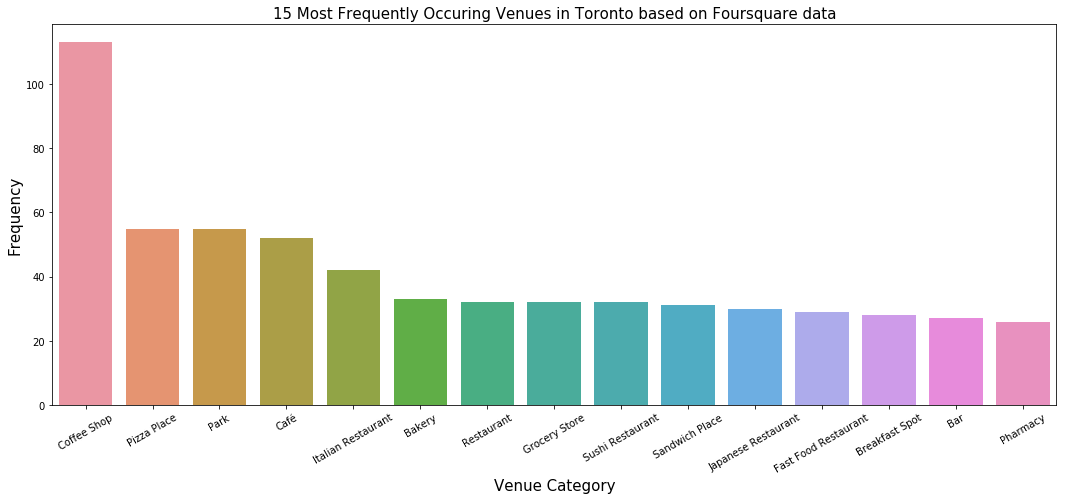

In [42]:
#Top 15 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=Toronto_Venues_Top15)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('15 Most Frequently Occuring Venues in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()

In [43]:
print(Toronto_venues.shape)
Toronto_venues.head(20)

(1588, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Summerhill Market,43.686265,-79.375458,Grocery Store
1,Rosedale-Moore Park,43.679563,-79.377529,Toronto Lawn Tennis Club,43.680667,-79.388559,Athletics & Sports
2,Rosedale-Moore Park,43.679563,-79.377529,Black Camel,43.677016,-79.389367,BBQ Joint
3,Rosedale-Moore Park,43.679563,-79.377529,Craigleigh Gardens,43.678099,-79.371586,Park
4,Rosedale-Moore Park,43.679563,-79.377529,Pie Squared,43.672143,-79.377856,Pie Shop
5,Rosedale-Moore Park,43.679563,-79.377529,Tinuno,43.671281,-79.374920,Filipino Restaurant
6,Rosedale-Moore Park,43.679563,-79.377529,Starbucks,43.671478,-79.380664,Coffee Shop
7,Rosedale-Moore Park,43.679563,-79.377529,Manulife Financial,43.672070,-79.382449,Office
8,Rosedale-Moore Park,43.679563,-79.377529,Booster Juice,43.671566,-79.378581,Smoothie Shop
9,Rosedale-Moore Park,43.679563,-79.377529,Aroma Espresso Bar,43.672154,-79.377885,Coffee Shop


In [44]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Agincourt North,Milliken",31,31,31,31,31,31
"Annex,Casa Loma",100,100,100,100,100,100
Banbury-Don Mills,32,32,32,32,32,32
Bay Street Corridor,100,100,100,100,100,100
"Bayview Village,Bayview Woods-Steeles",14,14,14,14,14,14
"Bedford Park-Nortown,Lawrence Park North",41,41,41,41,41,41
Birchcliffe-Cliffside,15,15,15,15,15,15
Church-Yonge Corridor,100,100,100,100,100,100
"East End-Danforth,The Beaches",80,80,80,80,80,80


In [45]:
print(Toronto_venues.shape)
Toronto_venues[Toronto_venues['Neighborhood']=='St.Andrew-Windfields']

(1588, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
518,St.Andrew-Windfields,43.75749,-79.374714,York Mills Collegiate Institute Swimming Pool,43.750994,-79.374365,Pool
519,St.Andrew-Windfields,43.75749,-79.374714,Talara Park,43.765457,-79.377301,Park
520,St.Andrew-Windfields,43.75749,-79.374714,St. Andrews Park,43.757309,-79.386616,Park
521,St.Andrew-Windfields,43.75749,-79.374714,Ames Park,43.751868,-79.365473,Park


In [46]:
#All Restaurant venues that contain Restaurant or BBQ on their category name
Toronto_restaurants = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant|BBQ|Bistro|Steakhouse|Noodle|Diner|Poke')].reset_index(drop=True)
print(Toronto_restaurants.shape)
Toronto_restaurants.head()

(435, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Black Camel,43.677016,-79.389367,BBQ Joint
1,Rosedale-Moore Park,43.679563,-79.377529,Tinuno,43.671281,-79.374920,Filipino Restaurant
2,Rosedale-Moore Park,43.679563,-79.377529,Nijo Japanese Restaurant,43.671849,-79.378824,Japanese Restaurant
3,Rosedale-Moore Park,43.679563,-79.377529,Caribbean Taste,43.671898,-79.378105,Caribbean Restaurant
4,Rosedale-Moore Park,43.679563,-79.377529,Maison Selby,43.671232,-79.376618,Bistro


In [47]:
#count number of restaurants for each neighbourhood
TNR_count=Toronto_restaurants.groupby('Neighborhood').agg('count')[['Venue Category']]
TNR_count.rename(columns={"Venue Category": "# Restaurants"}, inplace=True)
TNR_count.reset_index()

,Neighborhood,# Restaurants
0,"Agincourt North,Milliken",14
1,"Annex,Casa Loma",33
2,Banbury-Don Mills,10
3,Bay Street Corridor,27
4,"Bayview Village,Bayview Woods-Steeles",4
5,"Bedford Park-Nortown,Lawrence Park North",12
6,Birchcliffe-Cliffside,5
7,Church-Yonge Corridor,38
8,"East End-Danforth,The Beaches",15
9,"Eringate-Centennial-West Deane,Islington-City ...",2


In [48]:
# create a dataframe of top 10 restaurants categories
TNR_Top10 = Toronto_restaurants['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
TNR_Top10=TNR_Top10.reset_index()

TNR_Top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
TNR_Top10


,Venue Category,Frequency
0,Italian Restaurant,42
1,Sushi Restaurant,32
2,Restaurant,32
3,Japanese Restaurant,30
4,Fast Food Restaurant,29
5,Thai Restaurant,23
6,Chinese Restaurant,23
7,Vegetarian / Vegan Restaurant,15
8,Vietnamese Restaurant,15
9,American Restaurant,15


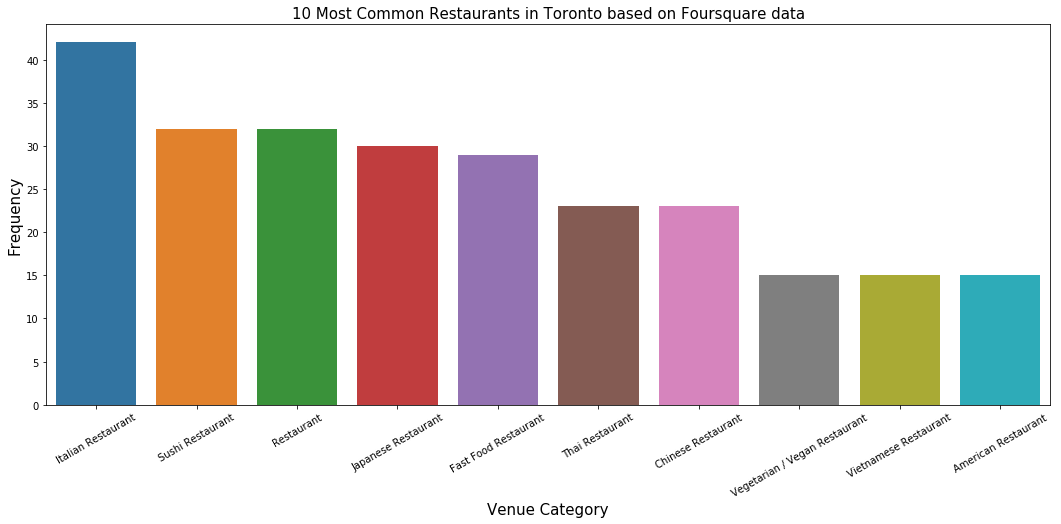

In [49]:

#Top 10 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=TNR_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Common Restaurants in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()


In [50]:
#Japanese Restaurant venues that contain Sushi or Japanese or Ramen on their category name
Toronto_Japanese_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Sushi|Japanese|Ramen')].reset_index(drop=True)
print(Toronto_Japanese_restaurant.shape)
Toronto_Japanese_restaurant

(75, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Nijo Japanese Restaurant,43.671849,-79.378824,Japanese Restaurant
1,Kingsway South,43.653654,-79.506944,Momiji Sushi Bar & Grill,43.647843,-79.508534,Sushi Restaurant
2,Kingsway South,43.653654,-79.506944,Sushi 2 Go,43.647875,-79.509427,Sushi Restaurant
3,Leaside-Bennington,43.709060,-79.363452,Kintako Japanese Restaurant,43.711597,-79.363962,Sushi Restaurant
4,Leaside-Bennington,43.709060,-79.363452,Maki Sushi,43.710127,-79.362466,Sushi Restaurant
5,Leaside-Bennington,43.709060,-79.363452,Nigiri-Ya,43.703218,-79.364279,Japanese Restaurant
6,"Annex,Casa Loma",43.672710,-79.405678,Gyubee,43.667088,-79.400571,Japanese Restaurant
7,"Annex,Casa Loma",43.672710,-79.405678,New Generation Sushi,43.665519,-79.409619,Sushi Restaurant
8,"Forest Hill South,Yonge-St.Clair",43.686412,-79.400049,Daeco Sushi,43.687838,-79.395652,Sushi Restaurant
9,"Forest Hill South,Yonge-St.Clair",43.686412,-79.400049,kibo sushi house,43.682727,-79.392270,Sushi Restaurant


In [51]:
#count number of japanese restaurants for each neighbourhood
df_JRC=Toronto_Japanese_restaurant.groupby('Neighborhood').agg('count')[['Venue Category']]
df_JRC.rename(columns={"Venue Category": "# Japanese_Restaurants"}, inplace=True)
df_JRC.reset_index(inplace=True)
df_JRC

,Neighborhood,# Japanese_Restaurants
0,"Annex,Casa Loma",2
1,Banbury-Don Mills,3
2,Bay Street Corridor,6
3,"Bayview Village,Bayview Woods-Steeles",2
4,"Bedford Park-Nortown,Lawrence Park North",1
5,Church-Yonge Corridor,10
6,"East End-Danforth,The Beaches",4
7,"Forest Hill South,Yonge-St.Clair",5
8,"High Park North,High Park-Swansea,Junction Area",3
9,Kingsway South,2


In [52]:
#Return locations with less than 3 Japanese restaurant
TN_JR=Toronto_Japanese_restaurant.groupby('Neighborhood').count()
TN_JR1=TN_JR[TN_JR['Venue Category']<3]
TN_JR1['Venue Category']

Neighborhood
Annex,Casa Loma                             2
Bayview Village,Bayview Woods-Steeles       2
Bedford Park-Nortown,Lawrence Park North    1
Kingsway South                              2
Rosedale-Moore Park                         1
South Riverdale                             2
York University Heights                     1
Name: Venue Category, dtype: int64

In [53]:
#Create the list of business it exclude restaurants and BBQ joints
Toronto_business = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Auto|Bakery|Bank|Bar|Brewery|Building|Business|Breakfast|Taco|Burrito|Butcher|store|Boutique|Coffee|Café|Cafe|Creperie|Club|Chiropractor|Concert|Deli|Entertainment|Athletics|Service|Pharmacy|Hotel|Hostel|Health|Storage|Soup|Snack|Sandwich|Salon|Tea|Grocery|Store|pub|Historic|Gym|Studio|Rock|Shop|Museum|Plaza|Gallery|Pub|Office|Theater|Mall|Market|market|Wings|Gas|Rental|Pizza')].reset_index(drop=True)
print(Toronto_business.shape)
Toronto_business.head()

(949, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale-Moore Park,43.679563,-79.377529,Summerhill Market,43.686265,-79.375458,Grocery Store
1,Rosedale-Moore Park,43.679563,-79.377529,Toronto Lawn Tennis Club,43.680667,-79.388559,Athletics & Sports
2,Rosedale-Moore Park,43.679563,-79.377529,Pie Squared,43.672143,-79.377856,Pie Shop
3,Rosedale-Moore Park,43.679563,-79.377529,Starbucks,43.671478,-79.380664,Coffee Shop
4,Rosedale-Moore Park,43.679563,-79.377529,Manulife Financial,43.672070,-79.382449,Office


In [54]:
#count number of business for each restaurant
df_BC=Toronto_business.groupby('Neighborhood').agg('count')[['Venue Category']]
df_BC.rename(columns={"Venue Category": "# Business"}, inplace=True)
df_BC.reset_index(inplace=True)
df_BC

,Neighborhood,# Business
0,"Agincourt North,Milliken",13
1,"Annex,Casa Loma",59
2,Banbury-Don Mills,18
3,Bay Street Corridor,64
4,"Bayview Village,Bayview Woods-Steeles",6
5,"Bedford Park-Nortown,Lawrence Park North",26
6,Birchcliffe-Cliffside,7
7,Church-Yonge Corridor,56
8,"East End-Danforth,The Beaches",54
9,Edenbridge-Humber Valley,8


In [55]:
#create a list with number of business greater than 10
TNB=df_BC[df_BC['# Business']>10]
TNB['# Business']

0     13
1     59
2     18
3     64
5     26
7     56
8     54
11    42
13    67
14    24
15    13
16    58
18    45
19    59
21    16
22    17
23    61
24    17
25    60
27    18
28    63
30    15
33    14
Name: # Business, dtype: int64

In [56]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 245 uniques categories.


In [57]:
df_BJP = pd.merge(df_BC, df_JRC, how='outer', on = 'Neighborhood').fillna(0)
df_BJPR = pd.merge(df_BJP, TNR_count, how='outer', on = 'Neighborhood').fillna(0)
df_BJPR.rename(columns={"Neighborhood": "Neighbourhood"}, inplace=True)

df_DemoVenues= pd.merge( df_PCDGfiltered, df_BJPR,how='outer', on = 'Neighbourhood').fillna(0)
df_DemoVenues['# Business']=df_DemoVenues['# Business'].astype(int)
df_DemoVenues['# Restaurants']=df_DemoVenues['# Restaurants'].astype(int)
df_DemoVenues['# Japanese_Restaurants']=df_DemoVenues['# Japanese_Restaurants'].astype(int)
df_DemoVenues

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants
0,M1G,Woburn,53485,12.31,4344,145933.058584,5,0,3
1,M1N,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109,7,0,5
2,M1R,Wexford/Maryvale,27917,10.25,2723,78067.678827,15,0,8
3,M1T,Tam O'Shanter-Sullivan,27446,5.41,5073,110348.666226,18,0,12
4,M1V,"Agincourt North,Milliken",55685,16.80,3314,110493.664337,13,0,14
5,M1W,"L'Amoreaux,Steeles",68616,11.69,5869,103520.299196,13,0,8
6,M2K,"Bayview Village,Bayview Woods-Steeles",34550,9.16,3771,70518.961182,6,2,4
7,M2L,St.Andrew-Windfields,17812,7.33,2430,150633.549340,0,0,0
8,M2N,"Lansing-Westgate,Willowdale East",66598,10.32,6453,107678.729014,58,14,37
9,M2R,"Westminster-Branson,Willowdale West",43210,6.49,6657,70267.476459,9,0,1


In [58]:
#df_DemoVenues exclude string neighbourhoods, borough, postal, code
df_DV=df_DemoVenues.drop(['Postcode','Neighbourhood'], axis=1)
df_DV.head()

,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants
0,53485,12.31,4344,145933.058584,5,0,3
1,22291,5.92,3765,85644.236109,7,0,5
2,27917,10.25,2723,78067.678827,15,0,8
3,27446,5.41,5073,110348.666226,18,0,12
4,55685,16.80,3314,110493.664337,13,0,14


In [59]:
col=['Population','Density','Area square km','Average Income', '# Business', '# Japanese_Restaurants', '# Restaurants']
df_DV.describe().round(1)

,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants
count,35.0,35.0,35.0,35.0,35.0,35.0,35.0
mean,34426.5,7.4,5870.7,126364.8,27.1,2.1,12.4
std,17303.2,5.3,4063.4,56434.2,23.2,3.2,12.2
min,9271.0,1.4,2085.0,70146.1,0.0,0.0,0.0
25%,22223.5,4.7,3453.5,89692.4,8.5,0.0,2.5
50%,27917.0,6.2,4684.0,110348.7,17.0,1.0,8.0
75%,43079.0,9.3,6555.0,148283.3,55.0,3.0,22.0
max,73604.0,29.9,23044.0,327842.4,67.0,14.0,38.0


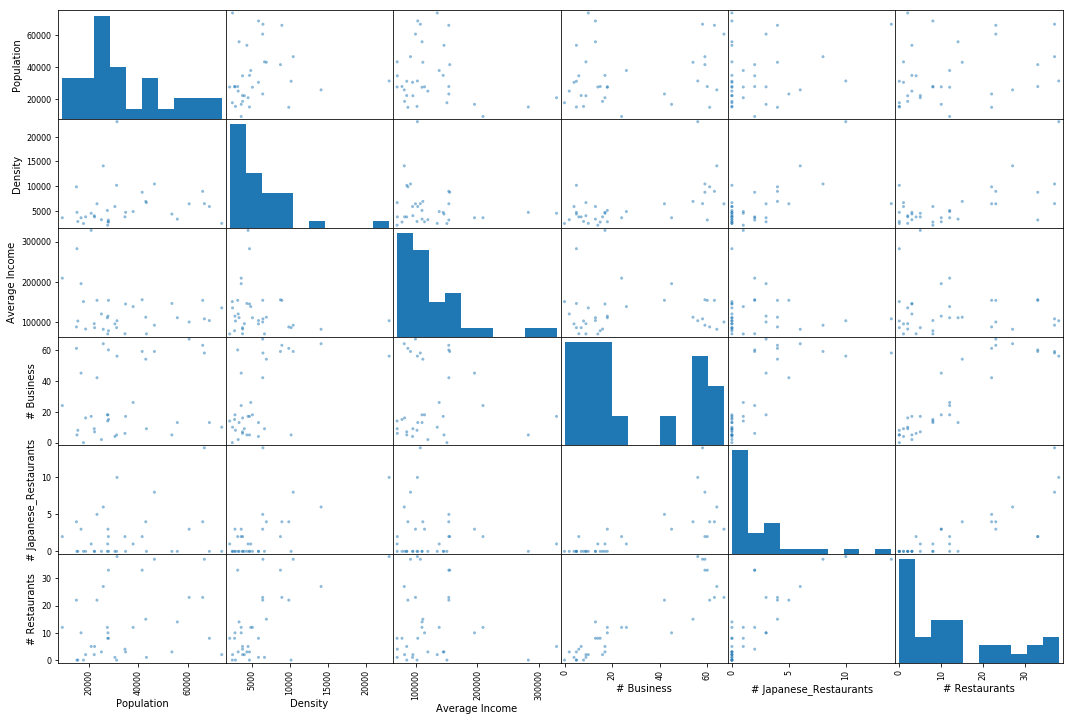

In [60]:

df_DVp=df_DV[['Population','Density','Average Income', '# Business', '# Japanese_Restaurants', '# Restaurants']]
scatter_matrix(df_DVp,figsize=(18,12))
#sns.pairplot(df_DVp, figsize=(18,12))
plt.show()


In [61]:
df_DV.corr(method='pearson')

,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants
Population,1.000000,0.637909,0.095340,-0.213518,0.218077,0.226078,0.262557
Area square km,0.637909,1.000000,-0.448334,-0.123913,-0.265530,-0.219690,-0.198380
Density,0.095340,-0.448334,1.000000,-0.168971,0.559000,0.609325,0.604199
Average Income,-0.213518,-0.123913,-0.168971,1.000000,-0.024265,-0.095769,-0.082828
# Business,0.218077,-0.265530,0.559000,-0.024265,1.000000,0.730854,0.898237
# Japanese_Restaurants,0.226078,-0.219690,0.609325,-0.095769,0.730854,1.000000,0.815435
# Restaurants,0.262557,-0.198380,0.604199,-0.082828,0.898237,0.815435,1.000000


In [62]:
df_DVC=df_DV.drop(['# Japanese_Restaurants','Density', '# Restaurants', 'Area square km'], axis=1)
df_DVC.corr(method='pearson')

,Population,Average Income,# Business
Population,1.000000,-0.213518,0.218077
Average Income,-0.213518,1.000000,-0.024265
# Business,0.218077,-0.024265,1.000000


In [63]:
df_DVC['Population']=df_DVC['Population'].astype(float)
df_DVC['Average Income']=df_DVC['Average Income'].astype(float)
df_DVC['# Business']=df_DVC['# Business'].astype(float)
df_std = StandardScaler().fit_transform(df_DVC.values)
df_std = pd.DataFrame(df_std, columns=df_DVC.columns)

df_std

,Population,Average Income,# Business
0,1.117523,0.351808,-0.966870
1,-0.711581,-0.732093,-0.879427
2,-0.381693,-0.868308,-0.529655
3,-0.409311,-0.287945,-0.398490
4,1.246523,-0.285338,-0.617098
5,2.004750,-0.410709,-0.617098
6,0.007242,-1.004022,-0.923149
7,-0.974214,0.436315,-1.185478
8,1.886422,-0.335947,1.350370
9,0.515034,-1.008543,-0.791984


In [64]:
df_DemoVenues.head()

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants
0,M1G,Woburn,53485,12.31,4344,145933.058584,5,0,3
1,M1N,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109,7,0,5
2,M1R,Wexford/Maryvale,27917,10.25,2723,78067.678827,15,0,8
3,M1T,Tam O'Shanter-Sullivan,27446,5.41,5073,110348.666226,18,0,12
4,M1V,"Agincourt North,Milliken",55685,16.80,3314,110493.664337,13,0,14


In [65]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_std)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 8, 6, 0, 1, 1, 6, 8, 4, 6], dtype=int32)

In [66]:
# add clustering labels
df_DemoVenues.insert(0, 'Cluster Labels', kmeans.labels_)

#Toronto_merged = df_TNCoords

# merge toronto venues, demographic and latitude/longitude for each neighborhood
Toronto_merged = pd.merge(df_DemoVenues, df_TNCoords, how='outer',on='Postcode')
Toronto_merged.set_index('Neighbourhood')
Toronto_merged=Toronto_merged.dropna()

In [67]:
Toronto_merged['Cluster Labels']=Toronto_merged['Cluster Labels'].astype(int)

In [68]:
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [69]:
print(rainbow)


['#8000ff', '#4062fa', '#00b5eb', '#40ecd4', '#80ffb4', '#c0eb8d', '#ffb360', '#ff5f30', '#ff0000']


In [70]:
df_TM=Toronto_merged.sort_values('Cluster Labels').reset_index(drop=True)
df_TM

,Cluster Labels,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,# Business,# Japanese_Restaurants,# Restaurants,Latitude,Longitude
0,0,M5M,"Bedford Park-Nortown,Lawrence Park North",37843.0,7.80,4851.0,138167.075770,26.0,1.0,12.0,43.733283,-79.419750
1,0,M3B,Banbury-Don Mills,27695.0,9.98,2775.0,114487.260303,18.0,3.0,10.0,43.745906,-79.352188
2,0,M1T,Tam O'Shanter-Sullivan,27446.0,5.41,5073.0,110348.666226,18.0,0.0,12.0,43.781638,-79.304302
3,0,M3A,Parkwoods-Donalda,34805.0,7.42,4690.0,144639.211442,17.0,0.0,3.0,43.753259,-79.329656
4,1,M9B,"Eringate-Centennial-West Deane,Islington-City ...",73604.0,29.94,2458.0,134993.473120,10.0,0.0,2.0,43.650943,-79.554724
5,1,M1G,Woburn,53485.0,12.31,4344.0,145933.058584,5.0,0.0,3.0,43.770992,-79.216917
6,1,M1V,"Agincourt North,Milliken",55685.0,16.80,3314.0,110493.664337,13.0,0.0,14.0,43.815252,-79.284577
7,1,M1W,"L'Amoreaux,Steeles",68616.0,11.69,5869.0,103520.299196,13.0,0.0,8.0,43.799525,-79.318389
8,2,M4E,"East End-Danforth,The Beaches",42948.0,6.22,6904.0,111729.976229,54.0,4.0,15.0,43.676357,-79.293031
9,2,M6R,Roncesvalles,14974.0,1.52,9851.0,87583.034848,61.0,4.0,22.0,43.648960,-79.456325


In [71]:
df_TM1=df_TM[(df_TM['# Business']>16)&(((df_TM['Population']>10000)&(df_TM['# Japanese_Restaurants']<3))&(df_TM['Density']>4000)|((df_TM['# Japanese_Restaurants']<5)&(df_TM['Population']>45000)))&(df_TM['# Restaurants']<25)]
df_TM1.reset_index(drop=True, inplace=True)
df_TM1.drop(['Postcode','Latitude','Longitude','Average Income'], axis=1)


,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,0,"Bedford Park-Nortown,Lawrence Park North",37843.0,7.80,4851.0,26.0,1.0,12.0
1,0,Tam O'Shanter-Sullivan,27446.0,5.41,5073.0,18.0,0.0,12.0
2,0,Parkwoods-Donalda,34805.0,7.42,4690.0,17.0,0.0,3.0
3,3,Rosedale-Moore Park,20923.0,4.65,4499.0,17.0,1.0,5.0
4,4,Waterfront Communities-The Island,65913.0,7.37,8943.0,63.0,4.0,23.0
5,4,"High Park North,High Park-Swansea,Junction Area",60453.0,9.42,6417.0,67.0,3.0,23.0


In [72]:
df_TM2=df_TM[(df_TM['# Restaurants']>=25)&(df_TM['# Business']>20)]
df_TM2.reset_index(drop=True, inplace=True)
df_TM2.drop(['Postcode','Latitude','Longitude','Average Income'], axis=1)

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,2,Church-Yonge Corridor,31340.0,1.36,23044.0,56.0,10.0,38.0
1,2,Bay Street Corridor,25797.0,1.83,14096.0,64.0,6.0,27.0
2,2,"Mount Pleasant East,Mount Pleasant West",46433.0,4.45,10434.0,59.0,8.0,37.0
3,4,"Lansing-Westgate,Willowdale East",66598.0,10.32,6453.0,58.0,14.0,37.0
4,7,South Riverdale,27876.0,8.89,3135.0,60.0,2.0,33.0
5,7,"Annex,Casa Loma",41494.0,4.74,8754.0,59.0,2.0,33.0


In [97]:
Toronto_mergedd=Toronto_merged.drop(['Postcode','Latitude','Longitude','Average Income'], axis=1)
cluster0=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 0]
cluster0.reset_index(drop=True, inplace=True)
cluster0

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,0,Tam O'Shanter-Sullivan,27446.0,5.41,5073.0,18.0,0.0,12.0
1,0,Parkwoods-Donalda,34805.0,7.42,4690.0,17.0,0.0,3.0
2,0,Banbury-Don Mills,27695.0,9.98,2775.0,18.0,3.0,10.0
3,0,"Bedford Park-Nortown,Lawrence Park North",37843.0,7.80,4851.0,26.0,1.0,12.0


In [98]:
cluster1=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 1]
cluster1.reset_index(drop=True, inplace=True)
cluster1

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,1,Woburn,53485.0,12.31,4344.0,5.0,0.0,3.0
1,1,"Agincourt North,Milliken",55685.0,16.80,3314.0,13.0,0.0,14.0
2,1,"L'Amoreaux,Steeles",68616.0,11.69,5869.0,13.0,0.0,8.0
3,1,"Eringate-Centennial-West Deane,Islington-City ...",73604.0,29.94,2458.0,10.0,0.0,2.0


In [99]:
cluster2=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 2]
cluster2.reset_index(drop=True, inplace=True)
cluster2

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,2,"East End-Danforth,The Beaches",42948.0,6.22,6904.0,54.0,4.0,15.0
1,2,"Mount Pleasant East,Mount Pleasant West",46433.0,4.45,10434.0,59.0,8.0,37.0
2,2,Church-Yonge Corridor,31340.0,1.36,23044.0,56.0,10.0,38.0
3,2,Bay Street Corridor,25797.0,1.83,14096.0,64.0,6.0,27.0
4,2,Roncesvalles,14974.0,1.52,9851.0,61.0,4.0,22.0


In [100]:
cluster3=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 3]
cluster3.reset_index(drop=True, inplace=True)
cluster3

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,3,Lawrence Park South,15179.0,3.24,4684.0,5.0,0.0,0.0
1,3,Rosedale-Moore Park,20923.0,4.65,4499.0,17.0,1.0,5.0


In [101]:
cluster4=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 4]
cluster4.reset_index(drop=True, inplace=True)
cluster4

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,4,"Lansing-Westgate,Willowdale East",66598.0,10.32,6453.0,58.0,14.0,37.0
1,4,Waterfront Communities-The Island,65913.0,7.37,8943.0,63.0,4.0,23.0
2,4,"High Park North,High Park-Swansea,Junction Area",60453.0,9.42,6417.0,67.0,3.0,23.0


In [102]:
cluster5=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 5]
cluster5.reset_index(drop=True, inplace=True)
cluster5

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,5,Leaside-Bennington,16828.0,4.68,3595.0,45.0,3.0,10.0
1,5,Kingsway South,9271.0,2.58,3593.0,24.0,2.0,12.0


In [103]:
cluster6=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 6]
cluster6.reset_index(drop=True, inplace=True)
cluster6

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,6,Wexford/Maryvale,27917.0,10.25,2723.0,15.0,0.0,8.0
1,6,"Bayview Village,Bayview Woods-Steeles",34550.0,9.16,3771.0,6.0,2.0,4.0
2,6,"Westminster-Branson,Willowdale West",43210.0,6.49,6657.0,9.0,0.0,1.0
3,6,York University Heights,27593.0,13.23,2085.0,14.0,1.0,8.0
4,6,Glenfield-Jane Heights,30491.0,5.20,5863.0,4.0,0.0,1.0
5,6,Niagara,31180.0,3.07,10156.0,5.0,0.0,0.0


In [104]:
cluster7=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 7]
cluster7.reset_index(drop=True, inplace=True)
cluster7

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,7,South Riverdale,27876.0,8.89,3135.0,60.0,2.0,33.0
1,7,"Forest Hill South,Yonge-St.Clair",23260.0,3.62,6425.0,42.0,5.0,22.0
2,7,"Annex,Casa Loma",41494.0,4.74,8754.0,59.0,2.0,33.0


In [105]:
cluster8=Toronto_mergedd.loc[Toronto_mergedd['Cluster Labels'] == 8]
cluster8.reset_index(drop=True, inplace=True)
cluster8

,Cluster Labels,Neighbourhood,Population,Area square km,Density,# Business,# Japanese_Restaurants,# Restaurants
0,8,Birchcliffe-Cliffside,22291.0,5.92,3765.0,7.0,0.0,5.0
1,8,St.Andrew-Windfields,17812.0,7.33,2430.0,0.0,0.0,0.0
2,8,O'Connor-Parkview,18675.0,4.94,3780.0,16.0,0.0,2.0
3,8,Stonegate-Queensway,25051.0,7.83,3199.0,2.0,0.0,3.0
4,8,Edenbridge-Humber Valley,15535.0,5.47,2840.0,8.0,0.0,0.0
5,8,Willowridge-Martingrove-Richview,22156.0,5.53,4006.0,9.0,0.0,2.0


In [82]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Zoo,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Noodle House,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale-Moore Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [83]:
Toronto_onehot.shape

(1588, 245)

In [84]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Zoo,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Noodle House,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Agincourt North,Milliken",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00000,0.0,0.0,0.00,0.0,0.0,0.0,0.064516,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00000,0.0,0.0,0.032258,0.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.032258,0.00,0.0,0.0,0.193548,0.0,0.0,0.0,0.0,0.00,0.0,0.032258,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.032258,0.00000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.032258,0.00,0.0,0.064516,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00000,0.032258,0.032258,0.000

In [85]:
Toronto_grouped.shape

(35, 245)

Print the top 10 most common venues for each selected neighbourhood based on their popularity

In [86]:
num_top_venues = 10
for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North,Milliken----
                  venue  freq
0    Chinese Restaurant  0.19
1          Noodle House  0.06
2           Pizza Place  0.06
3                Bakery  0.06
4  Fast Food Restaurant  0.06
5                  Park  0.06
6      Malay Restaurant  0.03
7           Event Space  0.03
8  Caribbean Restaurant  0.03
9        Shop & Service  0.03


----Annex,Casa Loma----
                           venue  freq
0                           Café  0.05
1                    Coffee Shop  0.05
2  Vegetarian / Vegan Restaurant  0.05
3             Italian Restaurant  0.04
4                         Bakery  0.04
5                     Restaurant  0.04
6                            Gym  0.03
7                  Grocery Store  0.03
8                    Pizza Place  0.03
9                         Museum  0.03


----Banbury-Don Mills----
                           venue  freq
0                    Pizza Place  0.09
1            Japanese Restaurant  0.09
2                   Burger Joint  0.0

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [88]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Agincourt North,Milliken",Chinese Restaurant,Park,Pizza Place,Fast Food Restaurant
1,"Annex,Casa Loma",Vegetarian / Vegan Restaurant,Coffee Shop,Café,Bakery
2,Banbury-Don Mills,Pizza Place,Japanese Restaurant,Burger Joint,Coffee Shop
3,Bay Street Corridor,Coffee Shop,Ice Cream Shop,Café,Bubble Tea Shop
4,"Bayview Village,Bayview Woods-Steeles",Japanese Restaurant,Grocery Store,Bank,Skating Rink


In [89]:
# set number of clusters
kclusters1 = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans1 = KMeans(n_clusters=kclusters1, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans1.labels_[0:5] 

array([0, 0, 0, 0, 0], dtype=int32)

In [90]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans1.labels_)

Toronto_merged1 = df_LocationDG

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged1 = Toronto_merged1.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged1=Toronto_merged1.dropna() 

In [91]:
Toronto_merged1['Cluster Labels']=Toronto_merged1['Cluster Labels'].astype(int)

In [92]:
 #create map
map_clusters1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x1 = np.arange(kclusters)
ys1 = [i + x + (i*x1)**2 for i in range(kclusters1)]
colors_array1 = cm.rainbow(np.linspace(0, 1, len(ys1)))
rainbow1 = [colors.rgb2hex(i) for i in colors_array1]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged1['Latitude'], Toronto_merged1['Longitude'], Toronto_merged1['Neighbourhood'], Toronto_merged1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow1[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

In [93]:
Toronto_merged1.sort_values('Cluster Labels').reset_index(drop=True)
Toronto_merged1

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M4W,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529,0,Coffee Shop,Grocery Store,Park,Bank
1,M4N,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790,0,College Gym,Park,College Quad,Gym / Fitness Center
2,M8X,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944,0,Coffee Shop,Park,Burger Joint,Dessert Shop
3,M4G,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452,0,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Electronics Store
4,M5R,"Annex,Casa Loma",41494,4.74,8754,155187.997998,43.672710,-79.405678,0,Vegetarian / Vegan Restaurant,Coffee Shop,Café,Bakery
5,M4V,"Forest Hill South,Yonge-St.Clair",23260,3.62,6425,153797.988109,43.686412,-79.400049,0,Coffee Shop,Park,Italian Restaurant,Sushi Restaurant
6,M4M,South Riverdale,27876,8.89,3135,153733.028955,43.659526,-79.340923,0,Coffee Shop,Bar,American Restaurant,Bakery
7,M5E,Waterfront Communities-The Island,65913,7.37,8943,153659.253917,43.644771,-79.373306,0,Coffee Shop,Hotel,Café,Beer Bar
8,M2L,St.Andrew-Windfields,17812,7.33,2430,150633.549340,43.757490,-79.374714,1,Park,Pool,Yoga Studio,Department Store
9,M1G,Woburn,53485,12.31,4344,145933.058584,43.770992,-79.216917,0,Coffee Shop,Park,Fast Food Restaurant,Indian Restaurant


Cluster 0 Information

In [94]:
df_cluster0=Toronto_merged1.loc[Toronto_merged1['Cluster Labels'] == 0]
df_cluster0.reset_index(drop=True, inplace=True)
df_cluster0

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M4W,Rosedale-Moore Park,20923,4.65,4499,327842.352420,43.679563,-79.377529,0,Coffee Shop,Grocery Store,Park,Bank
1,M4N,Lawrence Park South,15179,3.24,4684,282244.042538,43.728020,-79.388790,0,College Gym,Park,College Quad,Gym / Fitness Center
2,M8X,Kingsway South,9271,2.58,3593,208942.045617,43.653654,-79.506944,0,Coffee Shop,Park,Burger Joint,Dessert Shop
3,M4G,Leaside-Bennington,16828,4.68,3595,195253.063975,43.709060,-79.363452,0,Coffee Shop,Sporting Goods Shop,Furniture / Home Store,Electronics Store
4,M5R,"Annex,Casa Loma",41494,4.74,8754,155187.997998,43.672710,-79.405678,0,Vegetarian / Vegan Restaurant,Coffee Shop,Café,Bakery
5,M4V,"Forest Hill South,Yonge-St.Clair",23260,3.62,6425,153797.988109,43.686412,-79.400049,0,Coffee Shop,Park,Italian Restaurant,Sushi Restaurant
6,M4M,South Riverdale,27876,8.89,3135,153733.028955,43.659526,-79.340923,0,Coffee Shop,Bar,American Restaurant,Bakery
7,M5E,Waterfront Communities-The Island,65913,7.37,8943,153659.253917,43.644771,-79.373306,0,Coffee Shop,Hotel,Café,Beer Bar
8,M1G,Woburn,53485,12.31,4344,145933.058584,43.770992,-79.216917,0,Coffee Shop,Park,Fast Food Restaurant,Indian Restaurant
9,M3A,Parkwoods-Donalda,34805,7.42,4690,144639.211442,43.753259,-79.329656,0,Park,Pharmacy,Bus Stop,Convenience Store


Cluster 1 Information

In [95]:
df_cluster1 = Toronto_merged1.loc[Toronto_merged1['Cluster Labels'] == 1]
df_cluster1.reset_index(drop=True, inplace=True)
df_cluster1

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M2L,St.Andrew-Windfields,17812,7.33,2430,150633.54934,43.75749,-79.374714,1,Park,Pool,Yoga Studio,Department Store


Cluster 2 Information

In [96]:
df_cluster2=Toronto_merged1.loc[Toronto_merged1['Cluster Labels'] == 2]
df_cluster2.reset_index(drop=True, inplace=True)
df_cluster2

,Postcode,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M9B,"Eringate-Centennial-West Deane,Islington-City ...",73604,29.94,2458,134993.473120,43.650943,-79.554724,2,Park,Bank,Pizza Place,Theater
1,M8Y,Stonegate-Queensway,25051,7.83,3199,119843.838510,43.636258,-79.498509,2,Italian Restaurant,Park,Eastern European Restaurant,Ice Cream Shop
2,M3L,Glenfield-Jane Heights,30491,5.20,5863,95121.544626,43.739015,-79.506944,2,Park,Vietnamese Restaurant,Bank,Shopping Mall
